## Tutorial of RL for BrainMauration tasks

## 1. Imports

In [1]:
pwd

'/Users/jj/Documents/Projects/RL_BrainMaturation'

In [2]:
from tasks.task import Task, Instruction
from tasks.odr import ODR
from tasks.gap import Gap
from tasks.odr_distract import ODRDistract
from envs.environment import Environment

import ray
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.agents.a3c import A2CTrainer
from ray.tune.registry import register_env

import sys
import logging
import numpy as np
from typing import List

## 2. Basic APIs 

In [3]:
help(Instruction)

Help on class Instruction in module tasks.task:

class Instruction(builtins.object)
 |  Instruction(time: 'int', x: 'int', y: 'int', rng: 'Optional[np.random.Generator]' = None)
 |  
 |  This class defines where the signal displays on the screen
 |  
 |  Methods defined here:
 |  
 |  __init__(self, time: 'int', x: 'int', y: 'int', rng: 'Optional[np.random.Generator]' = None)
 |      Args:
 |          time: int
 |              The time when the instructure got released
 |          x: int
 |              The horizontal coordinate where the signal displays
 |          y: int
 |              The vertical coordinate where the signal displays
 |          rng: Optional[np.random.Generator] = None
 |              Optional numpy raomdom number generator to add an randomized component to the signal
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __

In [4]:
help(Task)

Help on class Task in module tasks.task:

class Task(builtins.object)
 |  Task(target_x: 'int', target_y: 'int', instructions: 'Dict[int, List[Instruction]]', tot_frames: 'int' = 5, width: 'int' = 42, height: 'int' = 42, encourage_mode: 'bool' = True, epsilon: 'float' = 1.0)
 |  
 |  This Task class defines the task to be learned.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, target_x: 'int', target_y: 'int', instructions: 'Dict[int, List[Instruction]]', tot_frames: 'int' = 5, width: 'int' = 42, height: 'int' = 42, encourage_mode: 'bool' = True, epsilon: 'float' = 1.0)
 |      Args:
 |          target_x: int
 |              The horizontal coordinate of the target focus point. The unit of the coordinate is pixel. 
 |          target_y: int
 |              The vertical coordinate of the target focus point. The unit of the coordinate is pixel.     
 |          instructions: List[Instruction]
 |              List of instructions 
 |          width: int
 |              The width of

In [5]:
help(ODR)

Help on class ODR in module tasks.odr:

class ODR(tasks.task.Task)
 |  ODR(target_x: 'int' = 1, target_y: 'int' = 5, width: 'int' = 42, height: 'int' = 42, encourage_mode: 'bool' = True)
 |  
 |  ODR task class.
 |  ODR task operates in the following 4 steps:
 |  1. fixation
 |  2. fixation + cue signal
 |  3. fixation
 |  4. no signal and expect to observe saccade toward the cue signal in step 2
 |  
 |  Method resolution order:
 |      ODR
 |      tasks.task.Task
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, target_x: 'int' = 1, target_y: 'int' = 5, width: 'int' = 42, height: 'int' = 42, encourage_mode: 'bool' = True)
 |      Args:
 |          target_x: int
 |              The horizontal coordinate of the target focus point. The unit of the coordinate is pixel.
 |          target_y: int
 |              The vertical coordinate of the target focus point. The unit of the coordinate is pixel.
 |          width: int
 |              The width of the screen.

In [6]:
customized_instructions = {
    0: [Instruction(time=0, x=5, y=5)],
    1: [Instruction(time=1, x=5, y=5), Instruction(time=1, x=1, y=5)],
    2: [Instruction(time=2, x=5, y=5, rng=np.random.default_rng())],
}
customized_task = Task(
    target_x=1,
    target_y=5,
    instructions=customized_instructions,
    tot_frames=4,
    width=42,
    height=42,
)

In [7]:
help(Environment)

Help on class Environment in module envs.environment:

class Environment(gym.core.Env)
 |  Environment(env_config: 'spaces.Dict[str, Task]') -> 'None'
 |  
 |  Environment class that simulate the environement of the brain maturation experiments.
 |  
 |  The environment assumes the observation is the 2D screen with 1 color channel. 
 |  The task of the brain maturation experiments is configged via the dictionary of env_config.
 |  
 |  Method resolution order:
 |      Environment
 |      gym.core.Env
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, env_config: 'spaces.Dict[str, Task]') -> 'None'
 |      Inits the env based on the env_config dictionary. 
 |      Args:
 |          env_config: Dict[str, Task]
 |              Environment config dictionary, i.e. env_config = {"task": Task}
 |  
 |  reset(self) -> 'np.ndarray'
 |      Reset the env to the initial config.
 |  
 |  step(self, action: 'spaces.Tuple[int, int]') -> 'Tuple[np.ndarray, float, bool, Dic

In [8]:
customized_env = Environment(env_config={"task": customized_task})

## 3. A trial run

In [9]:
ray.init()
np.random.seed(0)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger('Trace')

def env_creator(env_config):
    return Environment(env_config)  # return an env instance

register_env("my_env", env_creator) # register the env name

2020-10-10 11:57:34,412	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


Initialize the task:

In [10]:
task = ODR(target_x=1, target_y=5, width=42, height=42)
# task = Gap(target_x=1, target_y=5, width=42, height=42)
# task = ODRDistract(target_x=1, target_y=5, width=42, height=42)

Initialize the agent

In [11]:
# PPO agent
trainer = PPOTrainer(
    env="my_env",
    config={
        "env_config": {"task": task},
        "framework": "torch",
        "num_workers": 1,
        "train_batch_size": 10,
        "sgd_minibatch_size": 5,
        "num_sgd_iter": 10,
        # "model": {
        #     # Whether to wrap the model with an LSTM.
        #     "use_lstm": True,
        #     # Max seq len for training the LSTM, defaults to 20.
        #     "max_seq_len": task.tot_frames - 1,
        #     # # Size of the LSTM cell.
        #     "lstm_cell_size": task.tot_frames - 1,
        #     # # Whether to feed a_{t-1}, r_{t-1} to LSTM.
        #     # # "lstm_use_prev_action_reward": False,
        # },
    },
)


2020-10-10 11:57:35,847	INFO trainer.py:618 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-10-10 11:57:36,424	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [12]:
# A2C agent
trainer = A2CTrainer(
    env="my_env",
    config={
        "env_config": {"task": task},
        "framework": "torch",
        "num_workers": 1,
        "train_batch_size": 10,
        # "model": {
        #     # Whether to wrap the model with an LSTM.
        #     "use_lstm": True,
        #     # Max seq len for training the LSTM, defaults to 20.
        #     "max_seq_len": task.tot_frames - 1,
        #     # # Size of the LSTM cell.
        #     "lstm_cell_size": task.tot_frames - 1,
        #     # # Whether to feed a_{t-1}, r_{t-1} to LSTM.
        #     # # "lstm_use_prev_action_reward": False,
        # },
    },
)

2020-10-10 11:57:37,022	WARNING util.py:39 -- Install gputil for GPU system monitoring.


Initialize the env

In [13]:
env = Environment(env_config={"task": task})


Start RL learning

In [14]:
def train(rl_trainer, num_training_iterations: int=10)-> List:
    log = []
    for i in range(num_training_iterations):
        logger.info(f"Training iteration {i}...")
        rl_trainer.train()

        done = False
        cumulative_reward = 0.0
        observation = env.reset()

        while not done:
            action = rl_trainer.compute_action(observation)

            observation, reward, done, results = env.step(action)
            logger.info(f"Time: {env.time}. Action: {action}")
            cumulative_reward += reward
        logger.info(
            f"Last step reward: {reward: .3e}; Cumulative reward: {cumulative_reward:.3e}"
        )
        log.append([i, cumulative_reward])
    return log, rl_trainer

In [15]:
log, rl_trainer = train(trainer, 10)

INFO:Trace:Training iteration 0...
INFO:Trace:Time: 1. Action: (4, 21)
INFO:Trace:Time: 2. Action: (4, 9)
INFO:Trace:Time: 3. Action: (41, 13)
INFO:Trace:Last step reward:  0.000e+00; Cumulative reward: 0.000e+00
INFO:Trace:Training iteration 1...
INFO:Trace:Time: 1. Action: (0, 41)
INFO:Trace:Time: 2. Action: (5, 32)
INFO:Trace:Time: 3. Action: (14, 32)
INFO:Trace:Last step reward:  0.000e+00; Cumulative reward: 0.000e+00
INFO:Trace:Training iteration 2...
INFO:Trace:Time: 1. Action: (17, 39)
INFO:Trace:Time: 2. Action: (7, 33)
INFO:Trace:Time: 3. Action: (34, 41)
INFO:Trace:Last step reward:  0.000e+00; Cumulative reward: 0.000e+00
INFO:Trace:Training iteration 3...
INFO:Trace:Time: 1. Action: (1, 29)
INFO:Trace:Time: 2. Action: (29, 31)
INFO:Trace:Time: 3. Action: (8, 1)
INFO:Trace:Last step reward:  5.900e-29; Cumulative reward: 5.900e-29
INFO:Trace:Training iteration 4...
INFO:Trace:Time: 1. Action: (4, 4)
INFO:Trace:Time: 2. Action: (39, 26)
INFO:Trace:Time: 3. Action: (9, 41)
IN

In [16]:
trainer.get_policy().is_recurrent()

False

In [17]:
trainer.get_weights()["default_policy"].keys()

dict_keys(['_logits._model.1.weight', '_logits._model.1.bias', '_convs.0._model.1.weight', '_convs.0._model.1.bias', '_convs.1._model.1.weight', '_convs.1._model.1.bias', '_convs.2._model.0.weight', '_convs.2._model.0.bias', '_value_branch._model.0.weight', '_value_branch._model.0.bias'])

Multiple trials

In [18]:
num_runs = 10
num_training_iterations = 13
logs = []
for n in range(num_runs):
    logger.info(f"Run {n}...")
    trainer = A2CTrainer(
                env="my_env",
                config={
                    "env_config": {"task": task},
                    "framework": "torch",
                    "num_workers": 1,
                    "train_batch_size": 10,
                    })
    log, _ = train(trainer, num_training_iterations)
    logs.append(log)

ime: 2. Action: (1, 4)
INFO:Trace:Time: 3. Action: (1, 4)
INFO:Trace:Last step reward:  3.679e-01; Cumulative reward: 3.679e-01
INFO:Trace:Training iteration 6...
INFO:Trace:Time: 1. Action: (1, 4)
INFO:Trace:Time: 2. Action: (1, 4)
INFO:Trace:Time: 3. Action: (1, 4)
INFO:Trace:Last step reward:  3.679e-01; Cumulative reward: 3.679e-01
INFO:Trace:Training iteration 7...
INFO:Trace:Time: 1. Action: (1, 5)
INFO:Trace:Time: 2. Action: (1, 5)
INFO:Trace:Time: 3. Action: (1, 5)
INFO:Trace:Last step reward:  1.000e+00; Cumulative reward: 1.000e+00
INFO:Trace:Training iteration 8...
INFO:Trace:Time: 1. Action: (1, 5)
INFO:Trace:Time: 2. Action: (1, 5)
INFO:Trace:Time: 3. Action: (1, 5)
INFO:Trace:Last step reward:  1.000e+00; Cumulative reward: 1.000e+00
INFO:Trace:Training iteration 9...
INFO:Trace:Time: 1. Action: (1, 5)
INFO:Trace:Time: 2. Action: (1, 5)
INFO:Trace:Time: 3. Action: (1, 5)
INFO:Trace:Last step reward:  1.000e+00; Cumulative reward: 1.000e+00
INFO:Trace:Training iteration 10

Text(0.5, 1.0, "RL agent's learning curve")

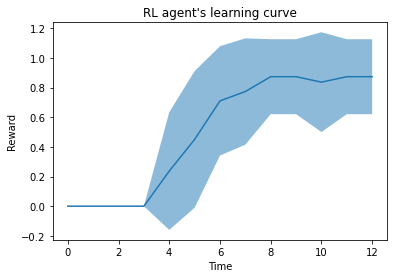

In [19]:
import matplotlib.pyplot as plt

logs = np.array(logs)
plt.plot(np.mean(logs, axis=0)[:,0], np.mean(logs, axis=0)[:,1])
plt.fill_between(np.mean(logs, axis=0)[:,0], 
                 np.mean(logs, axis=0)[:,1]- np.std(logs, axis=0)[:,1],  
                 np.mean(logs, axis=0)[:,1]+ np.std(logs, axis=0)[:,1], 
                 alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Reward")
plt.title("RL agent's learning curve")